# Data Mining Versuch Clustering von Pokemon

* Autoren: Manuel Eberhardinger, Johannes Theodoridis

## Abgabe:

- **Abzugeben ist das Jupyter Notebook mit dem verlangten Implementierungen und den entsprechenden Ausgaben.**
- **Das Notebook ist als .ipynb und als .html abzugeben.**
- **Klausurelevante Fragen sind Dokument "Fragenkatalog Datamining" zu finden.**
- Antworten auf Fragen im Notebook, Diskussionen und Beschreibung der Ergebnisse sind optional (aber empfohlen) und werden nicht bewertet.

* [Übersicht Data Mining Praktikum](https://maucher.pages.mi.hdm-stuttgart.de/ai/page/dm/)


# Einführung

## Lernziele:

In diesem Versuch sollen Kenntnisse in folgenden Themen vermittelt werden:

* Kennenlernen der Pokemon API
* Abfrage von Pokemon-Merkmalen über die API (Data Collection)
* Erstellen der Features für Pokemons (Feature Extraction + Data Preprocessing)
* Kennenlernen verschiedener Clustering-Algorithmen 
* Selektion der aussagekräftigsten Merkmale (Feature Selection)
* Clustering von ähnlichen Pokemons


## Vor dem Versuch zu klärende Fragen

### Kennenlernen der Pokemon API

In diesem Versuch wird die [Pokemon API](https://pokeapi.co/docs/v2) eingesetzt, um Features für verschiedene Pokemon über den [API Endpoint](https://pokeapi.co/docs/v2#pokemon) zu bekommen. Die API ist öffentlich verfügbar und man braucht somit keinen Account um Daten abfragen zu können. In diesem Versuch wollen wir keine fertige Library benutzen, die Daten für uns abfragen kann, sondern holen diese Daten mit der [requests](https://requests.readthedocs.io/en/latest/) Python-Bibliothek selber. 

1. Machen Sie sich mit der Pokemon API vertraut, speziell mit dem Pokemon endpoint. Diesen finden Sie über das Menü auf der Webseite: `Contents -> Pokémon -> Pokémon`.
2. Installieren Sie die Python-Bibliothek `requests` mit pip und führen Sie manuell ein paar beispielhafte Abfragen der Pokemon API durch. Benutzen Sie hierzu die `get` methode von requests mit einer endpoint URL. Eine Authentifizierung ist nicht notwendig. Versuchen Sie verschiedene IDs oder Namen aus und geben Sie den Statuscode sowie den Inhalt der response als Text oder JSON aus.
3. Welchen Python Datentyp liefert die Methoden `.json()` einer requests-Response zurück?

In [ ]:
import requests
from requests import Timeout, HTTPError, TooManyRedirects
from pprint import pprint
from PIL import Image
import io
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
# Diese EINstellung erlaubt uns alle Spalten eines pandas Dataframes auszugeben
pd.set_option('display.max_columns', None)

In [ ]:
r = requests.get('https://pokeapi.co/api/v2/pokemon/')

In [ ]:
r.status_code

In [ ]:
r.text

In [ ]:
r.json()

In [ ]:
def print_id_name():
    response = r.json()

    for i in range(10):
        pok_name = response['results'][i]['name']
        pok_id = requests.get(response['results'][i]['url']).json()['id']

        print(f'{pok_id} - {pok_name}')

In [131]:
print_id_name()

1 - bulbasaur
2 - ivysaur
3 - venusaur
4 - charmander
5 - charmeleon
6 - charizard
7 - squirtle
8 - wartortle
9 - blastoise
10 - caterpie
11 - metapod
12 - butterfree
13 - weedle
14 - kakuna
15 - beedrill
16 - pidgey
17 - pidgeotto
18 - pidgeot
19 - rattata
20 - raticate


3. Welchen Python Datentyp liefert die Methoden `.json()` einer requests-Response zurück?

In [ ]:
type(r.json())

4. Schauen Sie sich nochmal das Kapitel zum unüberwachten Lernen der KI-Vorlesung an: [https://lectures.mi.hdm-stuttgart.de/mi7ai/06Clustering.html#introduction](https://lectures.mi.hdm-stuttgart.de/mi7ai/06Clustering.html#introduction) (**user**: *mi7ai*, **pw**: *ailecture*)
5. Beschreibt kurz die Clustering-Verfahren KMeans und DBSCAN. Was sind die jeweiligen Vor- und Nachteile der beiden Verfahren? Worin unterscheiden sie sich?

### KMeans
Kurze Beschreibung:
- Bei dem KMeans CLusterung Verfahren werden anfangs zufällige Cluster Mitten ausgewählt
- Zu den Clustern werden die Trainingsdaten zugeteilt. bei welchen die Mitte am nähsten ist
- FÜr jedes Cluster wird die Mitte neu ermittelt in dem das Centroid von allen Trainigsdtaen berechnet wird, welche zu einem CLuster zugetilt wurden
- Wenn sich die Mitten der CLustern nicht mehr verschieben ist das CLustering fertig

<br>

Vorteile:
- K-means is simple and fast.
- Since it minimizes the reconstruction error it is often applied for all types of quantisation.
- For quantisation tasks usually the euclidean distance is applied in K-means. However, the algorithm can also be applied for any other distance-metric.

<br>

Nachteile:
- number of clusters must be defined by the user. What is a suitable cluster-number?
- Result depends on initial (random) cluster-setting?
- All elements are assigned to clusters - also outliers. Outliers may distort clusters.

### DBSCAN
Kurze Beschreibung:
- Die Idee hinter DBSCAN besteht aus dem clustern von zusammenhängenden BEreichen mit hoher Stichprobendichte. Die Rände dieser CLuster sind Bereiche mit niedriger Stichprobendichte. Punkte außerhalb dem CLuster werden als Noise gesehen und werden nicht betrachtet.

<br>

Vorteile:
- No need to specify number of clusters.
- Outliers are not assigned to clusters and they do not distort clusters like K-means
- Scales good even for large datasets

<br>

Nachteile:
- Even though the number of clusters need not be defined, two other parameters must be configured, which strongly influence the resulting clustering.
- For given configuration of parameters the result is not completely unique, because border-points may belong to not only one core-point.

### Unterschiedene zwischen KMeans und DBSCAN


# Durchführung
## 1. Data Collection, Feature Extraction & Preprocessing

Als Erstes müssen wir Daten über die API holen, damit wir diese für das Erstellen der Features benutzen können. Wir arbeiten hier nur mit Daten über Pokemons und nicht mit den verschiedenen Fertigkeiten oder Attacken. Diese können für weitere eigene Experimente benutzt werden. Diesmal installieren wir keine spezielle Bibliothek, sondern holen uns die Daten selber über die [requests](https://requests.readthedocs.io/en/latest/) Bibliothek. Damit wollen wir euch zeigen, dass es auch ohne spezielle Frameworks sehr leicht ist, Daten in Python zu crawlen. Die meisten APIs arbeiten heutzutage mit JSON, es gibt aber auch noch Ausnahmen, die z.B. mit XML arbeiten. [JSON-Objekte](https://requests.readthedocs.io/en/latest/user/quickstart/#json-response-content) kann requests ohne Probleme selber parsen, da ein JSON-Objekt einfach in ein Python-Dictionary umgewandelt werden kannn. 

**Aufgaben 1:**
1. Implementiert eine Funktion `call_api(endpoint, resource_id)`, die euch für verschiedene endpoints Daten in einem Dictionary zurückgeben kann. Die endpoint URL muss dabei dynamisch um die id (oder den Namen) erweitert werden.
2. Um HTTP Fehler zu bemerken ruft auf dem Response-Objekt die Methode `raise_for_status()` auf damit wir mögliche Exceptions später korrekt abfangen können.
3. Zum Testen der Methode, holt euch die Daten für Pikachu über den Endpoint `https://pokeapi.co/api/v2/pokemon/{id or name}/`. Pikachu hat die id 25. Was passiert bei id 0? Analysiert die erste Ebene des Dictionaries mit der `.keys()` Methode.

In [ ]:
def call_api(endpoints, resource_id):
    results = requests.get(f'{endpoints}/{resource_id}')
    results.raise_for_status()
    return results.json()

In [ ]:
endpoint = 'https://pokeapi.co/api/v2/pokemon'
resource_id = 25
resource_name = 'pikachu'

pprint(call_api(endpoints=endpoint, resource_id=resource_id))

In [ ]:
# call_api(endpoints=endpoint, resource_id=0)

**Antwort**: Bei `id=0` bekommen wir einen `404` Error, da kein EIntrag mit der `id=0` exiistiert.

In [ ]:
call_api(endpoints=endpoint, resource_id=resource_id).keys()

Durch das Aufrufen der `.keys()` FUnktion, bekommen wir eine Liste an features, welche in der API vorhanden und abrufbar sind.

4. Analysiert die Struktur bzw. die Datentypen der Keys `name, height, weight` sowie `stats` und `types` aus dem Dictionary mit der Beschreibung der API Dokumentation.

In [ ]:
result = call_api(endpoints=endpoint, resource_id=25)

print(f'''{result['id']}: {result['name']}
name:   {type(result["name"])}  # The name for this resource.
height: {type(result["height"])}  # The height of this Pokémon in decimetres.
weight: {type(result["weight"])}  # The weight of this Pokémon in hectograms.
stats:  {type(result['stats'])} # A list of base stat values for this Pokémon.
types:  {type(result['types'])} # A list of details showing types this Pokémon has.
''')

5. Gebt für Pikachu nun **manuell** den Name, Höhe und Gewicht, die Namen und Werte der Stats sowie die Typ(en) aus. Für Stats und Types ist eine geschachtelte Abfrage notwendig. Beachten Sie, dass manche Pokemons mehr als einen Typ haben können.

In [ ]:
result = call_api(endpoints=endpoint, resource_id=25)

print(f'''{result['id']}: {result['name']}
name:   {result["name"]}
height: {result["height"]}
weight: {result["weight"]}''')

print('stats:')
for i in result['stats']:
    print(i['stat']['name'], ':', i['base_stat'])
    
print('types:')
for i in result['types']:
    print('Type', ':', i['type']['name'])

**Aufgabe 2:**

1. Implementiert nun eine Funktion `parse_poke_dict(pokemon)`, die das Dictionary, das von der `call_api`-Funktion zurückgegeben wurde, in ein Dictionary mit ausgewählten Features umwandelt (reduziert). Verwendet dafür die Keys und Features aus der vorherigen Aufgabe.
2. Das neue Dictionary soll nicht mehr verschachtelt sein. Einzelne Stats werden also auf der selben Hierarchieebene wie `name`, `height` und `weight` eingefügt. Verfügbare Types werden als Keys verwendet und auf den Value `1` gesetzt. Das ermöglicht uns später eine einfache Umwandlung der Types in ein binäres Encoding mit Pandas (ähnlich zu One-Hot Encoding, ein Pokemon kann aber mehr als einen Type haben).
3. Vergleichen Sie die neue Methode mit der manuellen Abfrage um sicherzustellen, dass alle Features korrekt übernommen wurden.

In [ ]:
def parse_poke_dict(pokemon, feature_list):
    selected_features = {key:pokemon[key] for key in pokemon if key in feature_list}

    stats = selected_features['stats']
    for i in stats:
        selected_features[i['stat']['name']] = i['base_stat']

    types = selected_features['types']
    for j in types:
        selected_features[j['type']['name']] = 1

    selected_features.pop('stats', None)
    selected_features.pop('types', None)

    return selected_features

In [ ]:
feature_list = ['name', 'height', 'weight', 'stats', 'types']

result = call_api(endpoints=endpoint, resource_id=25)
flatten_result = parse_poke_dict(pokemon=result, feature_list=feature_list)
pprint(flatten_result)

**Aufgabe 3:**

1. Implementiert eine Funktion `get_img(pokemon)` welche ein noch nicht reduziertes Pokemon Dictionary akzeptiert und für dieses Pokemon das entsprechende Sprite (Bild) herunterlädt und zurück gibt. Hierzu ist ein weiterer `get`-Request notwendig.
2. Die Download URLs können über den Key 'sprites' abgfragt werden. Wir möchten die Ansicht 'front_default' herunterladen.
3. Der Inhalt der Response kann mit `.content` abgerufen werden. Um ein RGB-Bild zu erhalten muss dieser zunächst der Methode `BytesIO` und dann der Methode `Image.open` übergeben werden. Hierzu ist die `Pillow`-Bibliothek notwendig. Installiert diese also zunächst über pip und importiert dann das `Image`-Modul mit: `from PIL import Image`. Die `BytesIO`-Methode kann über die Python standard Bibliothek `io` importiert werden. Welchen Datentyp haben die Bilder die von der Methode zurückgegeben werden?
4. Für die Ausgabe der Bilder könnt ihr anstatt `print` die `display` Methode verwenden. Jupyter ruft diese implizit immer auf dem letzten Rückgabewert einer Zelle auf, daher werden Bilder angezeigt wenn sie der letzte Rückgabewert der Zelle waren.

In [ ]:
def get_img(pokemon):
    sprite = pokemon['sprites']['front_default']
    sprite = requests.get(sprite)

    image = io.BytesIO(sprite.content)
    image = Image.open(image)
    
    return image

In [ ]:
result = call_api(endpoints=endpoint, resource_id=25)

print(type(get_img(pokemon=result)))
display(get_img(pokemon=result))

**Aufgabe 4:**

Mit den bisher implementierten Methoden können wir nun unseren **Pokedex** erstellen. Dieser könnte zwar als Klasse implementiert werden, wir speichern die Daten und Bilder jedoch der Einfachheit halber separat in einem Pandas Dataframe und einem Numpy Array.

1. Implementiert eine Funktion `catch_them_all(n=151)`, welche für $n$ Pokemon die reduzierten Feature Dictionaries und Bilder sammelt. Wir verwenden $n=151$ als Default da das alle Pokemon aus der ersten Edition sind.
2. Verwendet die Methoden `call_api`, `parse_poke_dict` und `get_img` in einer Schleife um alle Pokemon abzufragen.
3. Die Dictionaries sollen zunächst in einer Python Liste gesammelt, und dann als Pandas Dataframe ausgegeben werden. Als Index soll dabei `name` verwendet werden. Was fällt bei der Betrachtung der kategorialen Einträge auf? Behebt das Problem in dem Ihr einen passenden Wert für fehlende Einträge setzt.
3. Die Bilder sammeln wir separat in einem Numpy Array. Da Numpy etwas picky sein kann wenn Objekte wie PNG Bilder abgespeichert werden sollen, erstellen wir die Listen nicht wie üblich mit `np.array([])` sondern mit `np.empty(shape=(n,), dtype=object)`. Um Objekte hinzuzufügen wird dann nicht wie üblich `np.append` verwendet sondern eine Zuweisung mit Index, also `a[i] = item`.
4. Der Grund warum wir hier ein Numpy array verwenden ist, dass wir später potentielle Cluster sehr einfach über eine Indize-Liste abfragen können, sowohl im Dataframe als auch im Array. Beispiel:

In [ ]:
def catch_them_all(n, feature_list, endpoint): # Grund für mehr Parameter?
    temp_list = []
    images = np.empty(shape=(n,), dtype=object)

    for i in tqdm(range(0, n)):
        try:
            result = call_api(endpoints=endpoint, resource_id=i+1)
            flatten_result = parse_poke_dict(pokemon=result, feature_list=feature_list)
            image = get_img(pokemon=result)
            images[i] = image
            temp_list.append(flatten_result)
        except ConnectionError as ce:
            print(f'Pokmon ID: {i}')
            print(f'{ce}: raise on the event of a network problem')
        except HTTPError as he:
            print(f'Pokmon ID: {i}')
            print(f'{he}: raise in the HTTP request returned an unsuccessful status code')
        except Timeout as te:
            print(f'Pokmon ID: {i}')
            print(f'{te}: raise if a request times out')
        except TooManyRedirects as tmre:
            print(f'Pokmon ID: {i}')
            print(f'{tmre}: raise if the request exceeds the confidgured number of maximum redirections')
    
    pok_df = pd.DataFrame(temp_list)
    pok_df = pok_df.set_index('name')
    return pok_df, images

In [ ]:
endpoint = 'https://pokeapi.co/api/v2/pokemon'
feature_list = ['name', 'height', 'weight', 'stats', 'types']
n = 151

pokemon_df, images_list = catch_them_all(n=n, feature_list=feature_list, endpoint=endpoint)

In [ ]:
pokemon_df.head()

In [ ]:
images_list

Problem: Bei den Types werden für alle Types, die ein Pokemon nicht verfügt, ein NaN eingefügt. Daraus folgen fehler bei der späteren Verarbeitung. Diese NaNs müssen durch 0 ersetzt werden, um ein One-Hot-Encoding format zu bekommen.

In [ ]:
pokemon_df = pokemon_df.fillna(0)

In [ ]:
pokemon_df.head()

In [ ]:
cluster_indices = 1

display(pokemon_df.iloc[cluster_indices])
display(images_list[cluster_indices])

4. Um eine Fortschrittsanzeige während des Downloads zu erhalten, installiert zunächst das Paket `tqdm`, importiert es dann wie folgt: `from tqdm.notebook import tqdm` und verwendet es in eurer Schleife, z.B. mit: `for i in tqdm(range(0, n)):`. Evtl. müssen noch die `ipywidgets` installiert werden.
5. Welche **Errors and Exceptions** können bei der Verwendung der [requests](https://requests.readthedocs.io/en/latest/user/quickstart/#errors-and-exceptions) Bibliothek auftreten? Listet diese in einer separaten Markdownzelle auf mit einer kurzen Erklärung der Fehler.

**Mögliche Errors und Exceptions**:
- `ConnectionError`, raise on the event of a network problem
- `HTTPError`, raise ig the HTTP request returned an unsuccessful status code
- `Timeout`, raise if a request times out
- `TooManyRedirects`, raise if the request exceeds the confidgured number of maximum redirections

6. Wie kann sichergestellt werden, dass die Schleife bei einem Fehler nicht abbricht? Implementiert eine geeignete Lösung damit die Schleife auch mit requests-Exceptions weiterläuft. Informiert die Benutzer*innen der Methode bei welcher ID ein Fehler aufgetreten ist und gebt zusätzlich die Exception bzw. die Info, die der Error liefert. Tipp zum Testen: In Python können Exceptions manuell getriggert werden, z.B. mit `raise KeyError('Hallo, das ist ein KeyError')`, spezifische Exceptions einer Bibliothek müssen davor allerdings importiert werden. Deaktiviert alle manuell ausgelösten Test-Exceptions wieder soblad ihr euch sicher seid, dass diese robust abgefangen werden.
7. Testet euren *Pokedex* in dem ihr die Indizelisten `[0,1,2]` und `[24,150]` ausgeben lasst und stellt sicher, dass die Zuordnung zwischen Dataframe und Bild Array passt. Die `display`-Methode eignet sich hier wieder für die Ausgabe.

In [ ]:
cluster_indices_1 = [0, 1, 2]
cluster_indices_2 = [24, 150]

In [ ]:
for i in cluster_indices_1:
    display(pokemon_df.iloc[i])
    display(images_list[i])

In [ ]:
for i in cluster_indices_2:
    display(pokemon_df.iloc[i])
    display(images_list[i])

Nachdem wir nun unser Dataset gesammelt haben sollten wir als Teil des Preprocessing noch sicherstellen, dass folgende Eigenschaften erfüllt sind: 

1. Keine Null- oder NaN-Werte im DataFrame.
2. Binäres Encoding der kategorischen Werte.
3. Skalieren der Werte mit einem MinMaxScaler.

Zwei davon haben wir schon als Teil der Feature Extraction erledigt. Um die Skalierung kümmern wir uns jetzt.

**Aufgabe 5:**

1. Instanziiert ein `from sklearn.preprocessing import MinMaxScaler` Objekt und wendet diesen auf den Dataframe an.
2. Die transformierten Daten sollen wieder in ein Pandas Dataframe umgewandelt werden. Die Columns sowie der Index sind dabei die Selben wie im unskalierten Dataframe.
3. Gebt die originalen und skalierten Daten aus, um die Dataframes zu vergleichen.
4. Importiert abschliesend die Bibliothek `seaborn` mit `import seaborn as sns` und analysiert die **skalierten numerischen Daten** mit einem [`sns.pairplot` (link)](https://seaborn.pydata.org/generated/seaborn.pairplot.html). Wählt dazu nur die numerischen Columns des Dataframes aus.
5. Beschreibt kurz Auffälligkeiten in den Verteilungen (falls vorhanden). 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(pokemon_df)
pokemon_df_scaled = scaler.transform(pokemon_df)
pokemon_df_scaled = pd.DataFrame(pokemon_df_scaled, columns=pokemon_df.columns, index=pokemon_df.index)

In [ ]:
pokemon_df.head()

In [ ]:
pokemon_df_scaled.head()

In [ ]:
import seaborn as sns

In [ ]:
pokemon_df_scaled_sns = pokemon_df_scaled.iloc[:, :8]
pokemon_df_scaled_sns.head()

In [ ]:
sns.pairplot(pokemon_df_scaled_sns)

- Die Kampf-irrelevanten Eigenschaftens sind jeweils links verteilt (height, weight). EIne Außnahme hat der Stat hp. (Wahrscheinlich damit die Kämpfe nicht zu lange gehen)
- Die Kapf-rellevanten Eigenschaften sind alle mitting verteilt, bis auf ein paar Ausreßer (ser schwache Pokemon vs. Legenadary Pokemon)
- weight und height korrelieren sehr stark --> kleine Pokemon snd meist aich leicht, große sind schwer (logisch)
- Die meisten Pokemon finden sich auf der linken Verteilung: Die meisten Pokemon sind klein
- Die Kamp-relevanten Eigenschaften sind in Bezug auf andere sehr weit verteilt im ganzen Scatterplot
- Es gibt nur sehr wenige Pokemon mit besonders hohen Werten in allen Kampf-relevanten Bereichen (Mewto & Mew?)

## 2. Data Visualization & Dimensionsreduktion

Konntet ihr bereits Cluster in den Daten ausfindig machen? Nein? Keine Sorge, wir auch nicht. 

In diesem Abschnitt verwenden wir daher die Principal Component Analysis (PCA) Methode um unsere hochdimensionalen Daten in einem 2D-Raum abzubilden. Diese Methode wird in einer späteren Übung noch genauer erklärt und benutzt. Hier soll sie einfach als Blackbox verwendet werden. Man sollte nur wissen, dass damit ein hochdimensionaler Raum auf wenige Dimensionen reduziert werden kann ohne dabei viel Information zu verlieren. Auch das Clustering werden wir in diesem reduzierten Raum durchführen. Bevor wir uns aber um die PCA kümmern implementieren wir noch ein paar hilfreiche Visualisierungsfunktionen mit denen wir später die gefundenen Cluster besser analysieren können.

**Aufgabe 6:**

1. Implementiert eine Funktion `plot_images(img_list)` die als Input ein Numpy Array mit Pillow Image Objekten akzeptiert und diese in einem fixen Grid visualisiert. Verwendet dazu die Bibliothek `matplotlib` mit `import matplotlib.pyplot as plt`.
2. Erstellt zunächst **eine** neue Figure mit einer geeigneten quadratischen figsize. Pillow Images können mit der Funktion `imshow` geplottet werden. Um die Plots in einm Grid anzuordnen kann die Funktion `add_subplot(nrows, ncols, index)` verwendet werden (index muss bei 1 starten), bei 151 Pokemon ist ein 13x13 Grid eine gute Wahl. Für jeden Subplot können die Achsen mit `plt.axis('off')` deaktiviert werden.
3. Um eine Liste zu iterieren und dabei auch den aktuellen Index zu erhalten kann die Funktion `enumerate(['a','b','c'])` verwendet werden (Achtung: Index startet bei 0).
4. **Nachdem** alle Subplots erstellt wurden, muss **einmal** `plt.show()` aufgerufen werden.
5. Testet die Funktion mit dem Indize Subset `[0,1,2,24]` und einmal mit allen Pokemon.

In [ ]:
import matplotlib.pyplot as plt

In [205]:
def plot_images(img_list):
    '''
    input: numpy-array mit Pillow Image Objekten
    output: fix Grid von den Pillow Image Objekten
    '''
    fig = plt.figure(figsize=(13, 13))
    
    for index, i in enumerate(img_list):
        fig.add_subplot(13, 13, index+1)
        plt.axis('off')
        plt.imshow(i)

plt.show()

In [ ]:
plot_images(images_list[[0, 1, 2, 24]])

**Aufgabe 7:**
    
1. Implementiert zwei Funktionen `plot_numerics(dataframe)` und `plot_categories(dataframe)` die als Input ein komplettes Dataframe akzeptieren aber jeweils nur die numerischen oder kategorischen Spalten visualisieren. Verwendet dazu wieder die Bibliothek `seaborn`.
2. Die Methoden sollen selbständig nur die numerischen oder kategorischen Spalten des Dataframes auswählen.
3. Für numerische Werte könnt ihr entweder ein [`sns.barplot` (link)](https://seaborn.pydata.org/generated/seaborn.barplot.html) oder [`sns.boxplot` (link)](https://seaborn.pydata.org/generated/seaborn.boxplot.html) verwenden. Damit wir später verschiedene Cluster miteinander vergleichen können ist eine konstante Y-Range sinnvoll, z.B. `plt.ylim(0,1.1)`.
4. Für kategorische Werte verwendet ihr ein `sns.barplot`. Per Default wendet seaborn hier den `estimator='mean'` auf die Daten an. Ist das für die kategorischen Columns eine geeignete Statistik? Mit welcher einfachen arithmetischen Funktion könnt ihr die Anzahl der binär codierten Kategorien zählen? Verwendet diese als estimator und wählt eine passende konstante Y-Range. Falls Fehlerbalken keine Sinn machen, können diese mit `errorbar=None` deaktiviert werden.
5. Die Labels der X-Achse können mit `plt.xticks(rotation=90)` rotiert werden.
6. Ruft in den Funktionen **noch nicht** `plt.show()` auf damit wir diese in einer Grid Darstellung verwenden können.
7. Testet eure Funktionen mit dem skalierten Dataframe.

In [ ]:
def plot_numerics(dataframe, ax):
    '''
    input: ganzes dataframe
    output: Visualisierung der numerischen Daten
    '''
    numeric_features = dataframe.iloc[:, :8]
    sns.boxenplot(numeric_features, ax=ax)
    plt.ylim(0, 1.1)
    

def plot_categories(dataframe, ax):
    '''
    input: ganzes dataframe
    output: Visualisierung der kategorischen Daten
    '''
    categoric_features = dataframe.iloc[:, 8:]
    sns.barplot(categoric_features, estimator=np.sum, ax=ax, errorbar=None) # Ist mean hier geeignet? : Sum, weil wir wolen die anzahl der Types wissen/sehen
    # plt.ylim(0, 50) # Sollte die Max mögliche ANzahl sein?

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

plot_numerics(pokemon_df_scaled, ax=axes[0])
axes[0].set_title('Numeric Values Boxplot')
axes[0].tick_params(axis='x', rotation=90)

plot_categories(pokemon_df_scaled, ax=axes[1])
axes[1].set_title('Categorial Values Barplot')
axes[1].tick_params(axis='x', rotation=90)

plt.show()

Die drei bisher implementierten Funktionen möchten wir nun dazu verwenden, um gefundene Cluster zu visualiseren. Mit der untenstehenden Funktion könnt Ihr euch zum Test Fake Cluster generieren. Später implementieren wir diese Datenstruktur mit den echten Clustern. Die Keys des Dictionaries sind die Cluster Namen, die Values jeweils eine Liste mit den Indizes der Pokemon, die zu diesem Cluster gehören.

In [186]:
def get_fake_cluster(n_cluster=3, items_per_cluster=10, n_pokemon=151):

    cluster_dict = {}
    fake_cluster = np.random.choice(n_pokemon, (n_cluster, items_per_cluster), replace=False)
    for i, c in enumerate(fake_cluster):
        cluster_dict[i] = c
    return cluster_dict

test_cluster = get_fake_cluster()
test_cluster

{0: array([ 14, 134, 141, 133,  68, 119,  89,  13, 102,  52], dtype=int32),
 1: array([ 78, 114, 126,  31,  10,  27,  76,  88, 139, 144], dtype=int32),
 2: array([  4,  70,  86,  81, 110,  21,  55, 107,  64,  91], dtype=int32)}

**Aufgabe 8:**

1. Implementiert eine Funktion `compare_cluster(cluster_dict, dataframe, image_array)`, welche als Parameter ein Cluster Dictionary, die Pokemon Daten und Pokemon Bilder akzeptiert und für jedes Cluster die Daten und Bilder visualisiert. Wir vergleichen dabei zunächst die numerischen Werte der Cluster, dann die kategorischen und zum Schluss die Bilder. Geht bei der folgenden Implementierung Schritt für Schritt vor!
2. Erstellt zunächst eine Figure für die numerischen Werte mit der Größe `(20,40)`.
3. Nun iterieren wir über das `cluster_dict`. Da die Cluster Namen nicht zwingend bei 0 starten, ist es gut über den Inhalt des Dictionaries mit `for i, (c_name, c_indices) in enumerate(cluster_dict.items())` zu iterieren.
4. Erstellt für jedes Cluster ein Subplot in einem 10x5 Grid. Damit könnten bis zu 50 Cluster visualisiert werden. Dies ist erstmal ausreichend. Meistens haben wir viel weniger Cluster, die wir vergleichen möchten.
5. Gebt jedem Subplot einen Titel, der den Cluster Namen anzeigt.
6. Benutzt die Cluster Indizes nun um ein Subset des Dataframes zu selektieren und plottet das Cluster mit der `plot_numerics` Funktion.
7. Nach der Schleife ruft ihr `fig.tight_layout(h_pad=1, w_pad=1)` und `plt.show()` auf. Die Layout Funktion könnt ihr in Kombination mit der Größe der Figure verwenden, um die Darstellung schöner zu machen (sollte aber schon passen).
8. Wiederholt die Schritte 2-7, aber ruft dieses mal die Funktion `plot_categories` auf.
9. Iteriert ein letztes mal über das Cluster Dictionary, selektiert nun aber die Bilder und verwendet `plot_images`. Gebt mit einem einfachen `print`-Befehl davor an, welches Cluster gerade angezeigt wird.
10. Testet die Methode mit 1,5 und 10 Clustern. Wird alles korrekt dargestellt? Achtung, es gibt hier nichts inhaltliches zu analysieren. Das sind bisher nur Test Cluster ;) Zeigt bei der Abgabe, dass es für 10 Cluster gut funktioniert.

In [207]:
def compare_cluster(cluster_dict, dataframe, image_array):

    fig, axes = plt.subplots(1, 5, figsize=(18, 5))
    
    for i, (c_name, c_indices) in enumerate(cluster_dict.items()):
        subset = dataframe.reset_index(drop=True)
        subset = subset.loc[c_indices]
        plot_numerics(subset, ax=axes[i])
        axes[i].set_title(f'Cluster: {c_name}')
        axes[i].tick_params(axis='x', rotation=90)
    
    fig.suptitle('Numeric Values')
    fig.tight_layout(h_pad=1, w_pad=1)
    plt.show()

    fig_cat, axes_cat = plt.subplots(1, 5, figsize=(18, 5))
    
    for i, (c_name, c_indices) in enumerate(cluster_dict.items()):
        subset = dataframe.reset_index(drop=True)
        subset = subset.loc[c_indices]
        plot_categories(subset, ax=axes_cat[i])
        axes_cat[i].set_title(f'Cluster: {c_name}')
        axes_cat[i].tick_params(axis='x', rotation=90)
    
    fig_cat.suptitle('Categoric Values')
    fig_cat.tight_layout(h_pad=1, w_pad=1)
    plt.show()

    # fig_img, axes_img = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (c_name, c_indices) in enumerate(cluster_dict.items()):
        subset_images = image_array[c_indices]
        plot_images(subset_images)
    
    # fig_img.suptitle('Pokemon Sprites')
    # fig_img.tight_layout(h_pad=1, w_pad=1)
    plt.show()


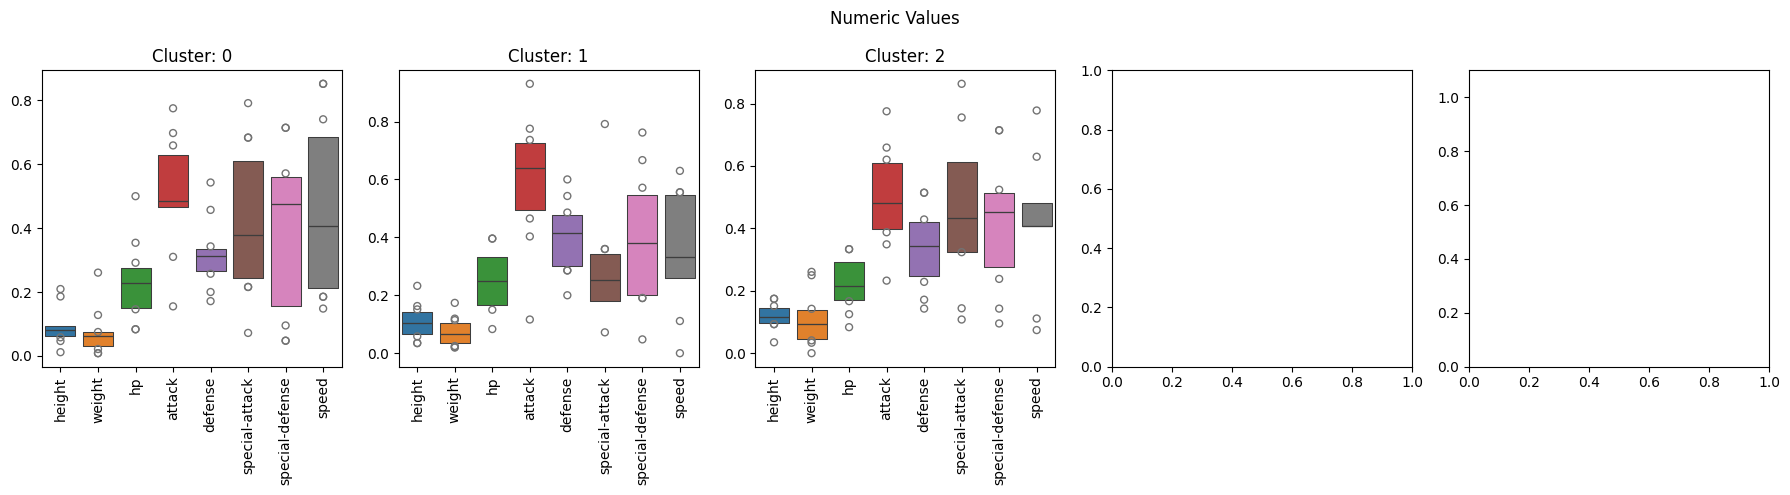

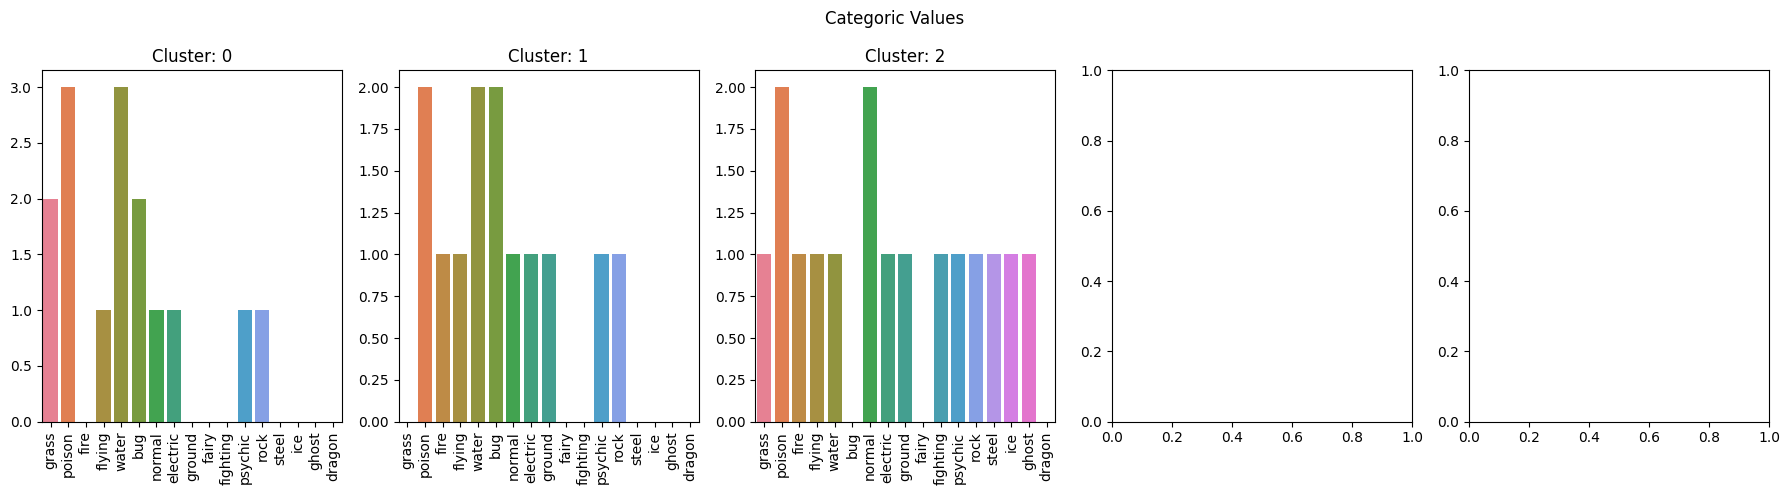

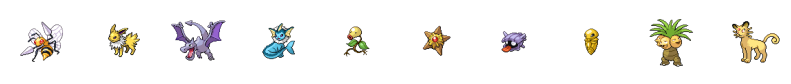

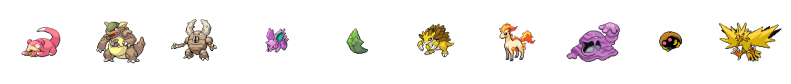

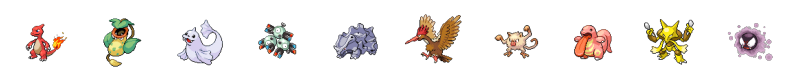

In [208]:
compare_cluster(cluster_dict=test_cluster, 
                dataframe=pokemon_df_scaled, 
                image_array=images_list
                )

Bisher können wir potentielle Cluster im hochdimensionalen Raum vergleichen, was uns erlaubt die Eigenschaften der gefundenen Cluster zu interpretieren. Für den Clustering-Algorithmus und die kompaktere Visualisierung wird empfohlen, eine Dimensionsreduktion mit der PCA-Methode durchzuführen, da dies eine gute Visualisierung der Daten in einem 2D-Raum ermöglicht.

**Aufgabe 9:**

1. Implementiert eine Funktion `apply_pca(dataframe)` welche ein skaliertes Dataframe akzeptiert und die Daten auf **zwei Dimensionen** reduziert.
2. Instanziiert ein [`from sklearn.decomposition import PCA` (link)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) Objekt. Wir möchten die Daten dabei auf zwei Komponenten reduzieren.
3. Wendet die PCA-Methode auf das Dataframe an. Die API ist dieselbe wie bei einem MinMaxScaler.
4. Die reduzierten Daten sollen wieder als Dataframe zurückgegeben werden. Der Index soll derselbe wie im ursprünglichem Dataframe sein.
5. Gebt den Dataframe vor und nach der Dimensionsreduktion aus. Mit der untenstehenden Funktion könnt ihr die auf zwei Dimensionen reduzierten Daten plotten. Der Index wird dabei als Hover Information angezeigt, sodass man erkennen kann welche Punkte wo liegen. Später können noch die Cluster Label und Cluster Center übergeben werden. Evtl. müsst ihr `plotly` installieren.

In [ ]:
import plotly.express as px

def plot_pca_data(pca_dataframe, c_labels=None, c_center=None):
    '''
    This function plots a dataframe with two dimensions. If a list of cluster labels (and/or cluster centers)
    is provided, these are set as color highlights. The index of the dataframe is used as hover information for
    the labels. Note that the input dataframe is left unchanged as we work on a copy!
    '''
    df = pca_dataframe.copy()
    df['Cluster'] = c_labels
    df = df.sort_values(by='Cluster')
    df['Cluster'] = df['Cluster'].astype('str')
    fig = px.scatter(df, x=0, y=1, color='Cluster', hover_data={'Name': df.index})
    
    if c_center is not None:
        l, c = len(px.colors.qualitative.Plotly), len(c_center)
        df, colors = pd.DataFrame(c_center), (px.colors.qualitative.Plotly * ((c // l) + 1))[:c]
        fig.add_scatter(x=df[0], y=df[1], name="Cluster Center", mode='markers', marker={'symbol':
                       'cross-thin-open', 'size':10, 'color': colors, 'opacity':1})
    
    fig.show()

In [ ]:
from sklearn.decomposition import PCA

In [209]:
def apply_pca(dataframe):
    pca = PCA(n_components=2)
    pca.fit(dataframe)
    x = pca.transform(dataframe)
    x = pd.DataFrame(x, index=dataframe.index)
    return x

In [210]:
pokemon_df_scaled.head()

,height,weight,hp,attack,defense,special-attack,special-defense,speed,grass,poison,fire,flying,water,bug,normal,electric,ground,fairy,fighting,psychic,rock,steel,ice,ghost,dragon
name,,,,,,,,,,,,,,,,,,,,,,,,,
bulbasaur,0.058140,0.014786,0.145833,0.341085,0.251429,0.359712,0.428571,0.222222,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ivysaur,0.093023,0.028050,0.208333,0.441860,0.331429,0.467626,0.571429,0.333333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
venusaur,0.209302,0.217221,0.291667,0.596899,0.445714,0.611511,0.761905,0.481481,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charmander,0.046512,0.018265,0.120833,0.364341,0.217143,0.323741,0.285714,0.370370,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charmeleon,0.104651,0.041096,0.200000,0.457364,0.302857,0.467626,0.428571,0.481481,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
pca_df = apply_pca(pokemon_df_scaled)
pca_df.head()

,0,1
name,,
bulbasaur,1.056084,0.273566
ivysaur,1.022966,0.270485
venusaur,0.962203,0.265069
charmander,-0.052749,-0.145640
charmeleon,-0.087702,-0.146718


In [212]:
plot_pca_data(pca_df)

## 3. Clustering mit dem KMeans Algorithmus

Im letzten Teil des Versuchs wenden wir nun endlich ein Clustering Verfahren an. Wie ihr sehen werded, ist dies sehr einfach und auch der Grund, warum sich die ganze Vorarbeit auszahlt :)

**Aufgabe 10:**

1. Implementiert eine Funktion `kmeans(dataframe, n_cluster)`, die ein noch nicht reduzierten Dataframe, sowie die Anzahl der gewünschten Cluster akzeptiert. Als Rückgabewert erstellen wir ein Cluster Dictionary, das wir dann in der `compare_cluster`-Methode zur Analyse und Interpretation der Cluster verwenden können.
2. Instanziiert ein [`from sklearn.cluster import KMeans` (link)](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) Objekt mit `n_cluster`.
3. Wendet die Methode `apply_pca` auf den Dataframe an und fittet den KMeans-Algorithmus auf die transformierten Daten.
4. Ruft die Methode `plot_pca_data` auf und übergebt zusätzlich die Liste der gefundenen Cluster Labels. Optional kann zusätzlich noch die Liste der Clusterzentren übergeben werden.
5. Als letzten Schritt konvertieren wir noch die Liste der Cluster Labels in ein Cluster Dictionary. Implementiert diesen Schritt zunächst in einer separaten Code Zelle und integriert diesen dann in die `kmeans`-Methode, wenn ihr euch sicher seid, dass alles funktioniert.
6. Schaut euch zunächst die Liste an Cluster Labels an, die der KMeans-Algorithmus erzeugt. Diese möchten wir in ein Dictionary mit dem selben Format wie die Fake Cluster bringen. Die Keys sollen dabei die Cluster IDs sein, die Values jeweils eine Liste mit den Indizes der Elemente, die diesem Cluster zugeordnet wurden. Mit der Methode `np.unique` könnt ihr überprüfen welche eindeutigen Cluster IDs es gibt. Iteriert dann über diese Liste an IDs und verwendet `np.where`, um zu sehen welche Elemente in der Label Liste diesem Cluster zugeordnet wurden (ihr bekommt jeweils eine Liste mit den Indizes der Elemente zurück). Baut damit ein Cluster Dictionary und gebt dieses als Rückgabewert aus.
7. Zeigt beispielhaft das Ergebnis eines Clusterings und dass `compare_cluster` korrekt mit eurem Cluster Dictionary umgehen kann.

In [166]:
from sklearn.cluster import KMeans

In [183]:
def kmeans(dataframe, n_cluster):
    kmeans = KMeans(n_clusters=n_cluster)
    dataframe = apply_pca(dataframe)
    kmeans.fit(dataframe)

    labels = kmeans.labels_
    cluster_dict = {k:None for k in np.unique(kmeans.labels_)}

    for i in np.unique(kmeans.labels_):
        cluster_dict[i] = np.where(labels == i)

    plot_pca_data(pca_dataframe=dataframe, c_labels=kmeans.labels_)
    print(cluster_dict.items())
    
    return cluster_dict

In [184]:
kmeans_data = kmeans(dataframe=pokemon_df_scaled, n_cluster=5)

dict_items([(np.int32(0), (array([  6,   7,   8,  53,  54,  59,  60,  61,  78,  79,  85,  86,  89,
        90,  97,  98, 115, 116, 117, 118, 119, 120, 128, 129, 130, 133,
       137, 138, 139, 140]),)), (np.int32(1), (array([  9,  10,  45,  46,  71,  72, 101, 102, 113]),)), (np.int32(2), (array([  3,   4,  24,  25,  26,  27,  34,  35,  36,  37,  49,  50,  55,
        56,  57,  58,  62,  63,  64,  65,  66,  67,  73,  74,  75,  76,
        77,  80,  81,  94,  95,  96,  99, 100, 103, 104, 105, 106, 110,
       111, 121, 123, 124, 125, 126, 134, 135, 146, 147, 149, 150]),)), (np.int32(3), (array([  5,  11,  15,  16,  17,  18,  19,  20,  21,  38,  39,  51,  52,
        82,  83,  84, 107, 112, 114, 122, 127, 131, 132, 136, 141, 142,
       143, 144, 145, 148]),)), (np.int32(4), (array([  0,   1,   2,  12,  13,  14,  22,  23,  28,  29,  30,  31,  32,
        33,  40,  41,  42,  43,  44,  47,  48,  68,  69,  70,  87,  88,
        91,  92,  93, 108, 109]),))])


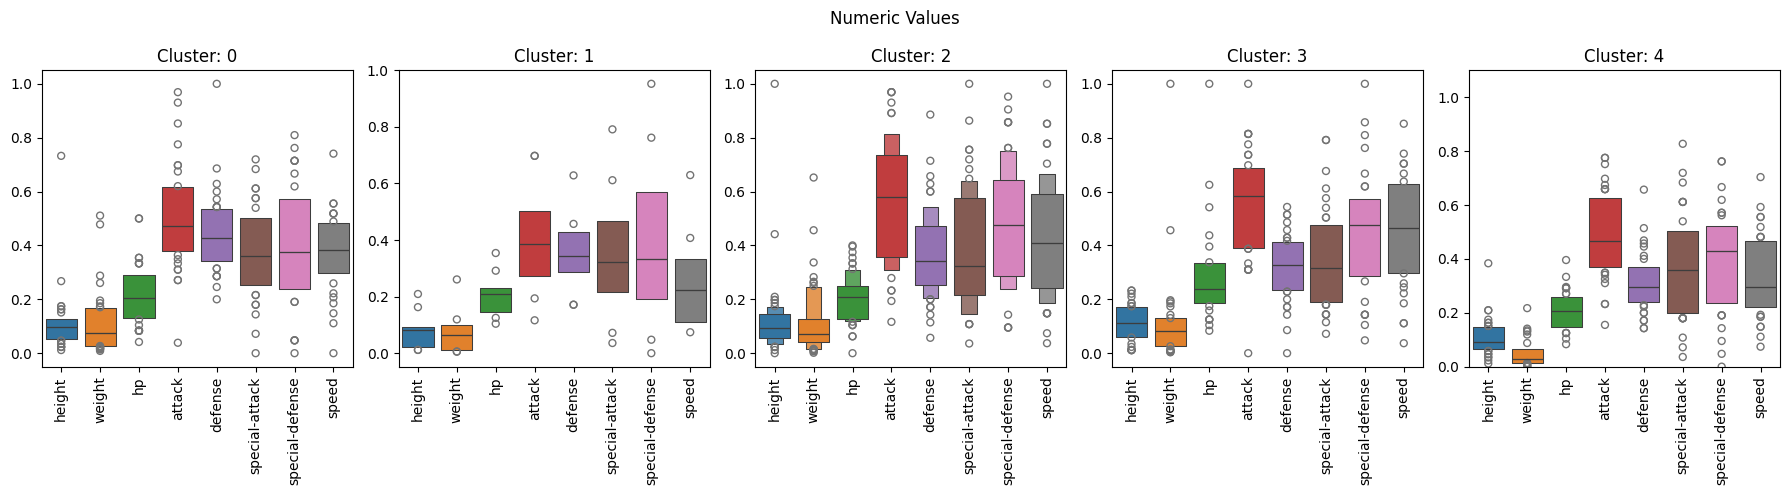

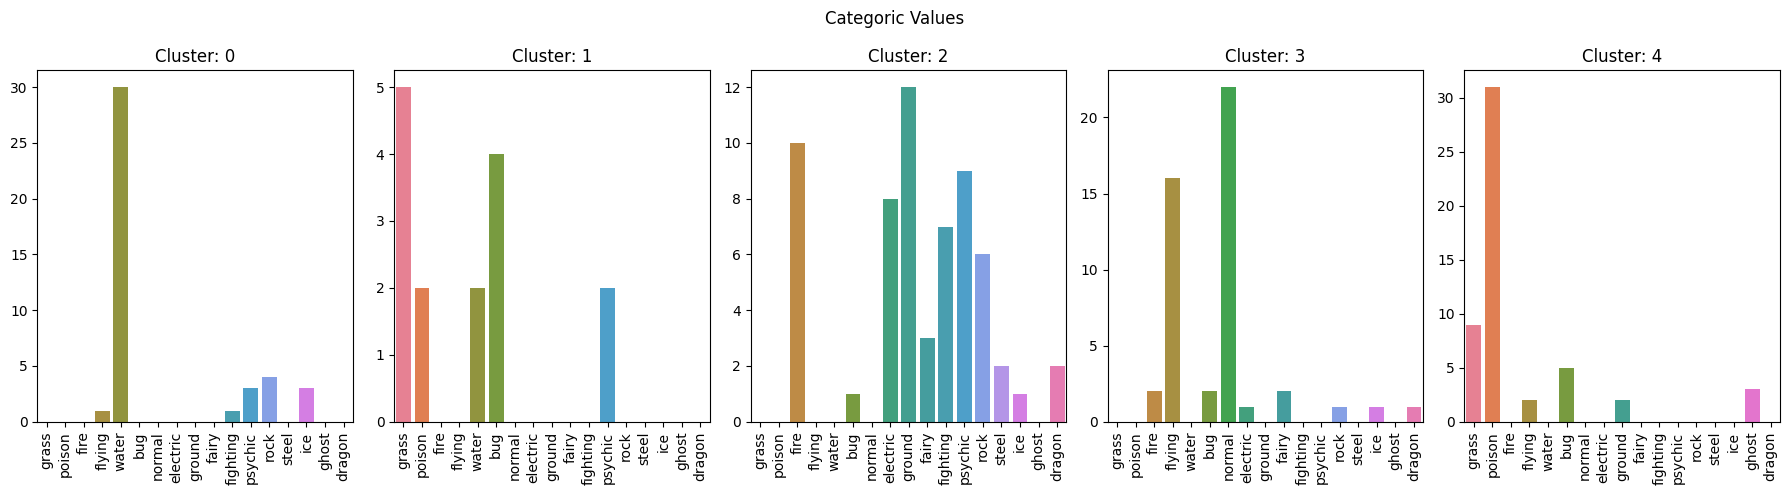

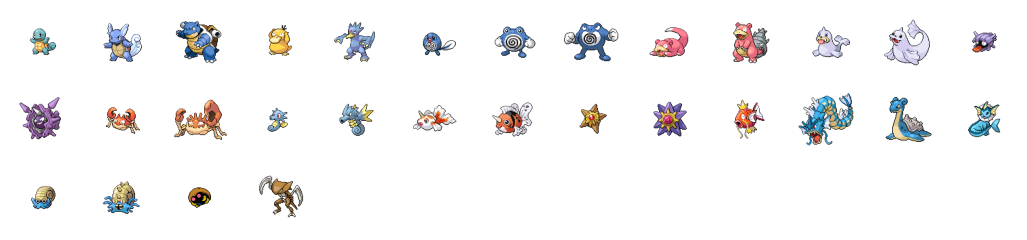

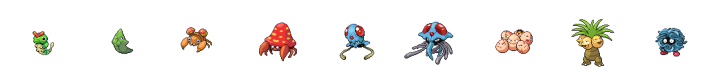

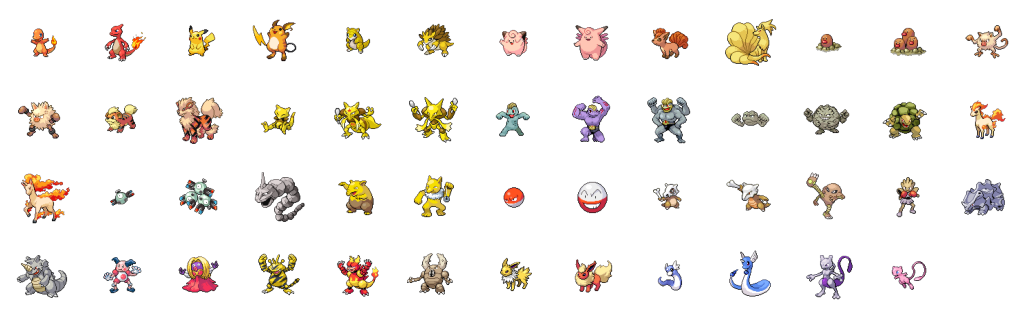

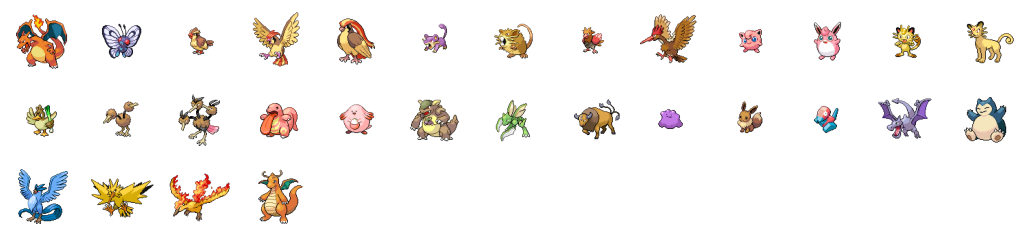

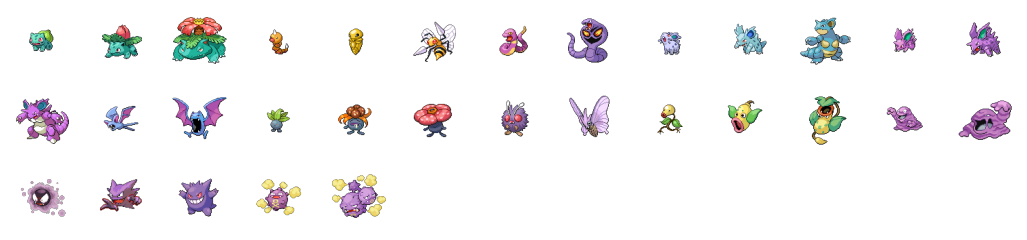

In [206]:
compare_cluster(kmeans_data,
                pokemon_df_scaled,
                images_list)

**Aufgabe 11**:

1. Visualisiert euch die PCA für **numerische und kategorische Werte**. Wie viele Cluster erwartet ihr zu finden? 
2. Wendet den KMeans-Algorithmus mit dieser Anzahl auf die Daten an. Entspricht das Clustering euren Erwartungen?
3. Was ist für euch subjektiv gesehen eine optimale Anzahl an Clustern?
4. Analysiert und diskutieren die gefundenen Cluster mit den implementierten Methoden. Welche Merkmale oder Arten von Merkmalen haben eurer Meinung nach den größten Einfluss auf das Clustering?
5. Optional: Beschreibt die gefundenen Cluster mit einer kurzen Zusammenfassung, z.B. "Cluster 1: Große blaue Dreiecke".

In [ ]:
plot_pca_data(pca_df) # 3?

In [ ]:
kmeans_data = kmeans(dataframe=pokemon_df_scaled, n_cluster=3) # Ja

dict_items([(np.int32(0), (array([  0,   1,   2,  12,  13,  14,  22,  23,  28,  29,  30,  31,  32,
        33,  40,  41,  42,  43,  44,  45,  46,  47,  48,  68,  69,  70,
        71,  87,  88,  91,  92,  93, 101, 108, 109, 113]),)), (np.int32(1), (array([  6,   7,   8,  53,  54,  59,  60,  61,  72,  78,  79,  85,  86,
        89,  90,  97,  98, 115, 116, 117, 118, 119, 120, 128, 129, 130,
       133, 137, 138, 139, 140]),)), (np.int32(2), (array([  3,   4,   5,   9,  10,  11,  15,  16,  17,  18,  19,  20,  21,
        24,  25,  26,  27,  34,  35,  36,  37,  38,  39,  49,  50,  51,
        52,  55,  56,  57,  58,  62,  63,  64,  65,  66,  67,  73,  74,
        75,  76,  77,  80,  81,  82,  83,  84,  94,  95,  96,  99, 100,
       102, 103, 104, 105, 106, 107, 110, 111, 112, 114, 121, 122, 123,
       124, 125, 126, 127, 131, 132, 134, 135, 136, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150]),))])


In [ ]:
# Your Markdown

**Aufgabe 12**:

1. Visualisiert euch die PCA nur für **numerische Werte**. Wie viele Cluster erwartet ihr zu finden? 
2. Wendet den KMeans Algorithmus mit dieser Anzahl auf die Daten an. Entspricht das Clustering euren Erwartungen?
3. Was ist für euch subjektiv gesehen eine optimale Anzahl an Clustern?
4. Analysiert und diskutieren die gefundenen Cluster mit den implementierten Methoden. Welche Merkmale oder Arten von Merkmalen haben eurer Meinung nach den größten Einfluss auf das Clustering?
5. Vergleicht die Ergebnisse mit denen aus Versuch 10.
5. Optional: Beschreibt die gefundenen Cluster mit einer kurzen Zusammenfassung, z.B. "Cluster 1: Kleine rote Kreise".

In [ ]:
# Your Code

In [ ]:
# Your Markdown

**Aufgabe 13:**

1. Berechnet für die gefundenen Cluster aus Aufgabe 11 und/oder 12 die [Elbow Methode](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) und den [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).
2. Was genau berechnet die Elbow Methode und der Silhouette Score?
3. Passen die Scores zu eurer bisherigen Interpretation?

In [ ]:
# Your Code

In [ ]:
# Your Markdown

**Aufgabe 13: (Verständnisfragen)**

1. Was ist die maximale Anzahl an möglichen Clustern, wenn die numerischen Werte Teil des Dataframes sind?
2. Was ist die maximale Anzahl an möglichen Clustern, wenn nur die kategorischen Daten verwendet würden?
3. Wie beurteilt ihr die Verwendung von kategorischen Merkmalen im Clustering? Konnten dadurch Cluster gefunden werden, die ihr ohne die Hilfe des Algorithmus nicht so einfach gefunden hättet?
4. Wie beurteilen Sie die Verwendung von numerischen Merkmalen im Clustering? Konnten dadurch Cluster gefunden werden, die ihr ohne die Hilfe des Algorithmus nicht so einfach gefunden hättet?

Begründet eure Antworten entweder theoretisch (nur Text) und/oder optional auch empirisch (mit Code).

In [ ]:
# Your Code (optional)

In [ ]:
# Your Markdown